# YouTube trending videos

In [214]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, precision_score, silhouette_score, roc_auc_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors

from helpers.categories import get_categories_dict
from helpers.files import load_csv

## Etap 4 - Wykorzystanie uczenia pół-nadzorowanego


Deklaracja potrzebnych funkcji

In [215]:
def show_stats(y_hat, y_hat_nans, y):
    mapping_dict = get_mapping_dict(y_hat_nans, y)
    print(mapping_dict)
    y_mapped = pd.Series(y).apply(lambda x: mapping_dict[x])
    print(f"Accuracy: {accuracy_score(y_hat, y_mapped)}")
    print(f"F1: {f1_score(y_hat, y_mapped, average='macro')}")
    print(f"Precision: {precision_score(y_hat, y_mapped, average='macro')}")
    print(f"Recall: {recall_score(y_hat, y_mapped, average='macro')}")
    y_hat = y_hat.to_numpy().reshape(-1, 1)
    y_mapped = y_mapped.to_numpy().reshape(-1, 1)
    encoder = OneHotEncoder(sparse=False)
    one_hot_hat = encoder.fit_transform(y_hat)
    y_hot = encoder.transform(y_mapped)
    print(f"ROC AUC Score OVR: {roc_auc_score(one_hot_hat, y_hot, multi_class='ovr')}")
    print(f"ROC AUC Score OVO: {roc_auc_score(one_hot_hat, y_hot, multi_class='ovo')}")

### Wyczytanie danych

In [216]:
gb_data, us_data = load_csv("clustering_data")

videos = pd.concat([gb_data, us_data])
categories_ids = videos["new_category_id"].dropna().unique().tolist()

### Wczytanie nazw kategorii

In [217]:
categories_dict = get_categories_dict()
categories = [categories_dict[cat] for cat in categories_ids]

## Usunięcie danych tekstowych

In [218]:
videos = videos[videos["new_category_id"].notna()]
y_hat = videos["new_category_id"]  # oczekiwane kategorie z api
y_hat_nans = videos["category_id"]  # oczekiwane kategorie z nanami (z oryginalnego zbioru)
videos_no_nan_categories = videos[videos["category_id"].notna()]
selected_columns = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day",
    "gray_mean_score", "color_mean_score", "gray_hist_score",
    "red_hist_score", "green_hist_score", "blue_hist_score", "edges_score", "entropy_score",
]

for cat in categories_ids:
    selected_columns.append(f"freq_channel_titles_{categories_dict[cat]}")
    selected_columns.append(f"freq_titles_{categories_dict[cat]}")
    selected_columns.append(f"freq_tags_{categories_dict[cat]}")
    selected_columns.append(f"freq_descriptions_{categories_dict[cat]}")

videos = videos[selected_columns]
videos = videos.fillna(videos.mean())

### Uzupełnienie wartości pustych wartościami średnimi


In [219]:
# videos = videos.fillna(videos.mean())

### Skalowanie danych

In [220]:
scaler = MinMaxScaler()
videos = scaler.fit_transform(videos)

array([2.35549979e-09, 1.78131603e-07, 5.14146483e-07, 6.14816714e-07,
       1.92566917e-04, 1.03092784e-02, 2.08333333e-02, 1.66666667e-01,
       4.34782609e-02, 6.32241137e-07, 7.61775913e-07, 7.23293515e-05,
       7.29003158e-05, 7.24731021e-05, 7.35905756e-05, 3.16455696e-04,
       4.14879799e-04, 5.00000000e+00, 2.85714286e+00, 2.22222222e+00,
       1.25000000e+00, 6.66666667e+00, 4.00000000e+00, 2.22222222e+00,
       1.33333333e+00, 1.00000000e+01, 3.33333333e+00, 2.22222222e+00,
       1.25000000e+00, 6.66666667e+00, 4.00000000e+00, 3.33333333e+00,
       1.33333333e+00, 1.00000000e+01, 4.00000000e+00, 2.22222222e+00,
       1.11111111e+00, 5.00000000e+00, 4.00000000e+00, 1.81818182e+00,
       1.25000000e+00, 6.66666667e+00, 2.85714286e+00, 3.33333333e+00,
       1.25000000e+00, 1.00000000e+01, 2.85714286e+00, 1.53846154e+00,
       1.33333333e+00, 4.00000000e+00, 5.00000000e+00, 1.11111111e+00,
       1.33333333e+00, 1.00000000e+01, 2.50000000e+00, 1.66666667e+00,
      

### Przygotowanie zbioru z oznaczonymi kategoriami

In [221]:
x_not_nan = videos[y_hat_nans.notna()]
y_not_nan = y_hat_nans[y_hat_nans.notna()]

### K-means

Dobre acc (przypisuje wszyskim jedną klasę ale słaba reszta metryk)
można zastosować bo znamy liczbę klas, do których będziemy przypisywać.

(8735, 40)


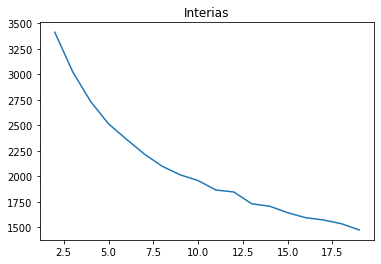

Cat len: 15
[ 0  7 12 ...  0  6  0]
{0: 24.0, 1: 24.0, 2: 17.0, 3: 10.0, 4: 25.0, 5: 28.0, 6: 24.0, 7: 24.0, 8: 24.0, 9: 23.0, 10: 26.0, 11: 25.0, 12: 1.0, 13: 10.0, 14: 27.0}
Accuracy: 0.4676588437321122
F1: 0.31612637920822756
Precision: 0.44552526988530317
Recall: 0.2960671029167505
ROC AUC Score OVR: 0.6250448168794897
ROC AUC Score OVO: 0.6250448168794897


c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


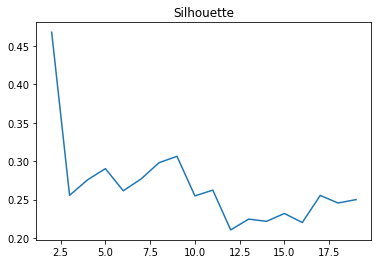

In [222]:
select = SelectKBest(chi2, k=40)
select.fit(x_not_nan, y_not_nan)
x = select.transform(videos)
print(x.shape)

k_list = np.arange(2, 20)
inertias = np.zeros_like(k_list, dtype=np.float)
silhouettes = np.zeros_like(k_list, dtype=np.float)
for i, k in enumerate(k_list):
    model = KMeans(k)
    # model.fit(x)
    labels = model.fit_predict(x)
    inertias[i] = model.inertia_
    silhouettes[i] = silhouette_score(x, labels)

plt.plot(k_list, inertias)
plt.title("Interias")
plt.show()
plt.plot(k_list, silhouettes)
plt.title("Silhouette")
print(f"Cat len: {len(categories)}")
model = KMeans(len(categories))
model.fit(x)
y = model.predict(x)
print(y)
show_stats(y_hat, y_hat_nans, y)


def get_mapping_dict(y_hat_nans, y_pred) -> dict:
    values_counts = y_hat_nans.value_counts().reset_index(name="count")
    # print(values_counts)
    # print(f"Index: {values_counts.index}")
    most_frequent_class = values_counts["index"].iloc[0]
    # print(most_frequent_class)
    mapping_dict = {}
    y_data = pd.DataFrame()
    y_data["y_hat_nans"] = y_hat_nans
    y_data["y"] = y_pred
    y_data["c"] = 1
    y_data = y_data.groupby(["y", "y_hat_nans"])["c"].sum()  #.max(level=[0])#.sort_values().groupby(level=0)
    # print(y_data)
    out = y_data.loc[y_data.groupby(level=0).idxmax()]
    # print(out)
    for row in out.index:
        mapping_dict[row[0]] = row[1]
    for i in range(np.unique(y_pred).shape[0]):
        if i not in mapping_dict.keys():
            mapping_dict[i] = most_frequent_class
    return mapping_dict

AHC - bo mamy zdefiniowaną liczbę grup?

In [223]:
model = AgglomerativeClustering(len(categories), compute_full_tree=True)
# model = DBSCAN(eps=0.6, min_samples=5)
model.fit(x)
y = model.labels_

show_stats(y_hat, y_hat_nans, y)

{0: 17.0, 1: 19.0, 2: 1.0, 3: 24.0, 4: 28.0, 5: 10.0, 6: 24.0, 7: 25.0, 8: 26.0, 9: 23.0, 10: 24.0, 11: 10.0, 12: 24.0, 13: 22.0, 14: 27.0}
Accuracy: 0.5014310246136233
F1: 0.3664973615791801
Precision: 0.4915926505675612
Recall: 0.36195280168134963
ROC AUC Score OVR: 0.6600414165005629
ROC AUC Score OVO: 0.6600414165005629


c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DBSCAN - bo mamy grupy różnej wielkości ?

In [224]:
model = DBSCAN(eps=0.1, min_samples=5)
model.fit(x)
y = model.labels_
show_stats(y_hat, y_hat_nans, y)

{-1: 24.0, 0: 24.0, 1: 17.0, 2: 10.0, 3: 10.0, 4: 10.0, 5: 10.0, 6: 10.0, 7: 24.0, 8: 24.0, 9: 26.0, 10: 10.0, 11: 24.0, 12: 22.0, 13: 22.0, 14: 22.0, 15: 24.0, 16: 24.0, 17: 24.0, 18: 24.0, 19: 10.0, 20: 24.0, 21: 23.0, 22: 27.0, 23: 24.0, 24: 24.0, 25: 24.0, 26: 26.0, 27: 24.0, 28: 17.0, 29: 24.0, 30: 10.0, 31: 24.0, 32: 25.0, 33: 10.0, 34: 22.0, 35: 10.0, 36: 17.0, 37: 10.0, 38: 25.0, 39: 26.0, 40: 10.0, 41: 10.0, 42: 10.0, 43: 10.0, 44: 1.0, 45: 22.0, 46: 27.0, 47: 10.0, 48: 10.0, 49: 26.0, 50: 10.0, 51: 10.0, 52: 10.0, 53: 10.0, 54: 1.0, 55: 22.0, 56: 24.0, 57: 24.0, 58: 28.0, 59: 19.0, 60: 24.0, 61: 24.0, 62: 10.0, 63: 26.0, 65: 10.0, 66: 24.0, 67: 10.0, 68: 10.0, 69: 1.0, 70: 10.0, 71: 17.0, 72: 17.0, 73: 10.0, 74: 24.0, 75: 20.0, 76: 25.0, 77: 23.0, 78: 23.0, 79: 23.0, 80: 10.0, 81: 10.0, 82: 10.0, 83: 10.0, 84: 23.0, 85: 17.0, 86: 24.0, 87: 10.0, 88: 22.0, 89: 15.0, 90: 24.0, 91: 24.0, 92: 24.0, 93: 1.0, 94: 24.0, 96: 10.0, 97: 10.0, 98: 23.0, 99: 10.0, 100: 24.0, 101: 24.0, 1

c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### DBSCAN eps Tuning

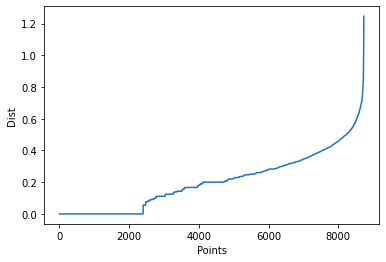

In [225]:
nn = NearestNeighbors(n_neighbors=11)
neighbors = nn.fit(x)
dist, ind = neighbors.kneighbors()

dist = np.sort(dist[:, 10], axis=0)

plt.plot(dist)
plt.xlabel("Points")
plt.ylabel("Dist")
plt.show()